<a href="https://colab.research.google.com/github/KETI-saisc/new/blob/main/anomaly_for_face_id_with_optimizer_scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -V

Python 3.9.16


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os

In [4]:
# Define constants
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 0.001
TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/data/anomaly/training/'
TEST_DIR = '/content/drive/MyDrive/Colab Notebooks/data/anomaly/testing/'
CLASSES = ['users', 'others']
NUM_CLASSES = len(CLASSES)

In [5]:
# Define dataset class
class PGMImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for class_index, class_name in enumerate(CLASSES):
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                image_path = os.path.join(class_dir, filename)
                self.images.append(image_path)
                self.labels.append(class_index)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

In [7]:
# Create dataset and data loaders
train_dataset = PGMImageDataset(root_dir=TRAIN_DIR, transform=train_transforms)
test_dataset = PGMImageDataset(root_dir=TEST_DIR, transform=test_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 25 * 25, 64)
        self.fc2 = nn.Linear(64, NUM_CLASSES)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 25 * 25)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
  
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 6 * 6)
        x = torch.relu(self.bn5(self.fc1(x)))
        x = torch.relu(self.bn6(self.fc2(x)))
        x = self.fc3(x)
        return x

class DeepDeepNet(nn.Module):
    def __init__(self):
        super(DeepDeepNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        batch_size = x.size(0)  # 현재 배치 크기 가져오기
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(batch_size, 256 * 6 * 6)
        x = torch.relu(self.bn5(self.fc1(x)))
        x = torch.relu(self.bn6(self.fc2(x)))
        x = self.fc3(x)
        return x

In [9]:
# Define loss function and optimizer
model = DeepDeepNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Best model saved at epoch 21 with loss: 0.007572
[Epoch 21] loss: 0.007572
Best model saved at epoch 22 with loss: 0.006796
[Epoch 22] loss: 0.006796
Best model saved at epoch 23 with loss: 0.005620
[Epoch 23] loss: 0.005620
[Epoch 24] loss: 0.012329
[Epoch 25] loss: 0.009110
Best model saved at epoch 26 with loss: 0.005196
[Epoch 26] loss: 0.005196
Best model saved at epoch 27 with loss: 0.004609
[Epoch 27] loss: 0.004609
[Epoch 28] loss: 0.005697
[Epoch 29] loss: 0.004822
[Epoch 30] loss: 0.004978
[Epoch 31] loss: 0.004784
Best model saved at epoch 32 with loss: 0.004107
[Epoch 32] loss: 0.004107
[Epoch 33] loss: 0.004129
[Epoch 34] loss: 0.004611
[Epoch 35] loss: 0.004833
Best model saved at epoch 36 with loss: 0.003651
[Epoch 36] loss: 0.003651
[Epoch 37] loss: 0.003962
Best model saved at epoch 38 with loss: 0.002961
[Epoch 38] loss: 0.002961
[Epoch 39] loss: 0.003513
Best model saved at epoch 40 with loss: 0.002798
[Epoch 40] loss: 0.002798
[Epoch 41] loss: 0.004014
[Epoch 42] lo

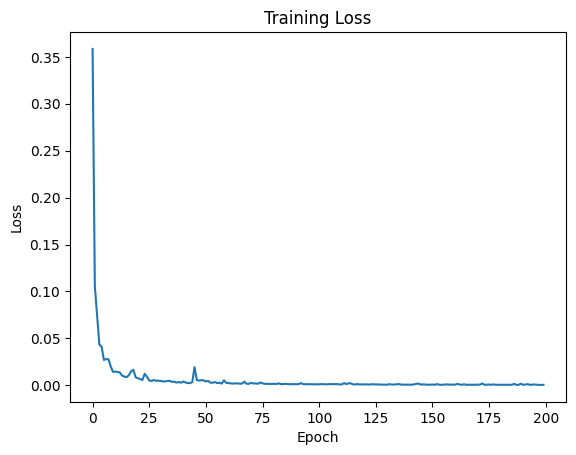

In [10]:


# # # Train the model
# # loss_list = []
# # for epoch in range(EPOCHS):
# #     running_loss = 0.0
# #     for i, data in enumerate(train_loader, 0):
# #         inputs, labels = data
# #         optimizer.zero_grad()
# #         outputs = model(inputs)
# #         loss = criterion(outputs, labels)
# #         loss.backward()
# #         optimizer.step()
# #         running_loss += loss.item()
        
# #     epoch_loss = running_loss / len(train_loader)
# #     loss_list.append(epoch_loss)
# #     print('[Epoch %d] loss: %.6f' % (epoch + 1, epoch_loss))

    

# #     if (epoch + 1) == 50:
# #         torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(50)+"_batch_"+str(BATCH_SIZE)+"_anomaly_2.pt")
# #     elif (epoch + 1) == 100:
# #         torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(100)+"_batch_"+str(BATCH_SIZE)+"_anomaly_2.pt")
# #     elif (epoch + 1) == 150:
# #         torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(150)+"_batch_"+str(BATCH_SIZE)+"_anomaly_2.pt")
# #     elif (epoch + 1) == 200:
# #         torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(200)+"_batch_"+str(BATCH_SIZE)+"_anomaly_2.pt")
# #     elif (epoch + 1) == 300:
# #         torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(300)+"_batch_"+str(BATCH_SIZE)+"_anomaly_2.pt")
# #     elif (epoch + 1) == 400:
# #         torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(400)+"_batch_"+str(BATCH_SIZE)+"_anomaly_2.pt")

# # # Show loss graph
# # plt.plot(loss_list)
# # plt.title('Training Loss')
# # plt.xlabel('Epoch')
# # plt.ylabel('Loss')
# # plt.show()


# # # Define the optimizer and scheduler
# # optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# # scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00005, 
#                                               step_size_up=5, max_lr=0.0001, 
#                                               gamma=0.5, mode='exp_range')



# for epoch in range(EPOCHS):
#     running_loss = 0.0
    
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
        
#     epoch_loss = running_loss / len(train_loader)
#     loss_list.append(epoch_loss)
#     print('[Epoch %d] loss: %.6f' % (epoch + 1, epoch_loss))
    
#     # Check if the current model has the best validation loss so far
#     with torch.no_grad():
#         val_loss = 0.0
#         for i, data in enumerate(train_loader, 0):
#             inputs, labels = data
#             outputs = model(inputs)
#             val_loss += criterion(outputs, labels).item()

#         val_loss /= len(train_loader)
#         if val_loss < best_loss:
#             best_loss = val_loss
#             filename = "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(epoch + 1)+"_batch_"+str(BATCH_SIZE)+"_anomaly_3.pt"
#             torch.save(model.state_dict(), filename)
#             print('Best model saved at epoch %d with validation loss: %.6f' % (epoch + 1, val_loss))

#         # if (epoch + 1) == 50:
#         #     torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(50)+"_batch_"+str(BATCH_SIZE)+"_anomaly_3_forcedsave.pt")
#         # elif (epoch + 1) == 100:
#         #     torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(100)+"_batch_"+str(BATCH_SIZE)+"_anomaly_3_forcedsave.pt")
#         # elif (epoch + 1) == 150:
#         #     torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(150)+"_batch_"+str(BATCH_SIZE)+"_anomaly_3_forcedsave.pt")
#         # elif (epoch + 1) == 200:
#         #     torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(200)+"_batch_"+str(BATCH_SIZE)+"_anomaly_3_forcedsave.pt")
            
#     # Adjust the learning rate if the validation loss plateaus
#     scheduler.step(epoch_loss)

# # Show loss graph
# plt.plot(loss_list)
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.8)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00005, 
#                                               step_size_up=5, max_lr=0.0001, 
#                                               gamma=0.5, mode='exp_range')
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Train the model
loss_list = []
best_loss = float('inf')
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
 
    epoch_loss = running_loss / len(train_loader)
    loss_list.append(epoch_loss)
    if (epoch+1) > 20:
        if epoch_loss < best_loss - 0.0001:
            best_loss = epoch_loss
            filename = "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(epoch+1)+"_batch_"+str(BATCH_SIZE)+"_anomaly_5.pt"
            torch.save(model.state_dict(), filename)
            print('Best model saved at epoch %d with loss: %.6f' % (epoch + 1, epoch_loss))

        print('[Epoch %d] loss: %.6f' % (epoch + 1, epoch_loss))


    if (epoch + 1) == 20:
        torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(20)+"_batch_"+str(BATCH_SIZE)+"_anomaly_55.pt")
    if (epoch + 1) == 30:
        torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(30)+"_batch_"+str(BATCH_SIZE)+"_anomaly_55.pt")
    if (epoch + 1) == 50:
        torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(50)+"_batch_"+str(BATCH_SIZE)+"_anomaly_55.pt")
    elif (epoch + 1) == 100:
        torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(100)+"_batch_"+str(BATCH_SIZE)+"_anomaly_55.pt")
    elif (epoch + 1) == 150:
        torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(150)+"_batch_"+str(BATCH_SIZE)+"_anomaly_55.pt")
    elif (epoch + 1) == 200:
        torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(200)+"_batch_"+str(BATCH_SIZE)+"_anomaly_55.pt")

    

# Show loss graph
plt.plot(loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
correct = 0
total = 0
predicted = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, batch_predicted = torch.max(outputs.data, 1)
        predicted += batch_predicted.tolist()
        total += labels.size(0)
        correct += (batch_predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 92.00%


In [12]:
torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(EPOCHS)+"_batch_"+str(BATCH_SIZE)+"_anomaly.pt")

In [13]:
device = torch.device('cpu')
# model.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/model/model_epoch"+str(EPOCHS)+"_batch_"+str(BATCH_SIZE)+"_anomaly.pt", map_location=device))
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/model/model_epoch21_batch_32_anomaly_2.pt', map_location=device))
model.eval()

DeepDeepNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=1024, bias=True)
  (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn6): BatchNo

In [14]:
# Set model to evaluation mode
model.eval()

# Iterate over test dataset and compare predictions with labels
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    for j in range(len(inputs)):
print('Image %d: Predicted %s, Actual %s' % (i*len(inputs)+j, CLASSES[predicted[j]], CLASSES[labels[j]]))

IndentationError: ignored

In [ ]:
model.eval()
# test_data = "/content/drive/MyDrive/Colab Notebooks/data/test/s0/1.1.pgm"
DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# Iterate over test dataset and compare predictions with labels
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    for j in range(len(inputs)):
        print('Image %d: Predicted %s, Actual %s' % (i*len(inputs)+j, CLASSES[predicted[j]], CLASSES[labels[j]]))